In [2]:
import pandas as pn
import numpy as np
import seaborn as sns 
from sklearn import linear_model, metrics
from pandas import Series
from pandas import DataFrame

import matplotlib.pyplot as plt

# Regresja liniowa z regularyzacją


#### 1. Ładowanie danych
Dane najlepiej załadować do struktury takiej, jak [DataFrame](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html). Oczywiście można radzić sobie inaczej, ale chyba nie warto.

#### 2. Wstępne opisanie danych i brakujące wartości
Za pomocą metody takiej, jak [`describe`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.describe.html) warto zbadać, co faktycznie jest w dataframie. Często chcemy się pozbyć brakujących danych (choć niektóre metody sobie z nimi nieźle radzą). Praca z brakującymi danymi dobrze opisana jest [tutaj](http://pandas.pydata.org/pandas-docs/stable/missing_data.html). 

#### 3. Rysowanie wykresów
Dużo metod lepiej działa na "ładnych" danych. Nie mamy już co prawda brakujących wartości, ale to 1/3 sukcesu. W wielu przypadkach chcemy też pozbyć się "outlierów" (przykładowo, jeśli przewidujemy ceny mieszkań i widzimy, że mamy jedno o powierzchni powyżej 10000m^2 i astronomicznej cenie, co zaburza nam wszystkie statystyki). Równie niechętnie patrzymy na skośne rozkłady -- w idealnym świecie wszystkie przypominałyby rozkład normalny. Warto pomyśleć o zlogarytmowaniu całej kolumny, to często pomaga. Wykresy, a zwłaszcza [histogramy](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.plot.hist.html#pandas.DataFrame.plot.hist), pomagają nam lepiej poznać rozkłady poszczególnych kolumn.

#### 4. Przetwarzanie danych
Oprócz usuwania outlierów i prostowania rozkładów możemy chcieć wykonać jeszcze szereg modyfikacji na danych, przykładowo:
* zakodować zmienne kategoryczne jako numerki (https://scikit-learn.org/stable/modules/preprocessing_targets.html#preprocessing-targets)
* znormalizować dane
* usunąć szumy
* zmniejszyć wymiarowość

Tutaj użytkownikom Pythona warto polecić moduł [Scikit Learn](https://scikit-learn.org/stable/index.html).

#### 5. trenowanie modeli

Chcemy wytrenować na naszych danych łącznie cztery modele:
* Zwykłą regresję liniową
* Regresję z regularyzacją L1 (Lasso)
* Regresję z regularyzacją L2 (Ridge)
Wszystkie trzy są ładnie opisane [tutaj](https://scikit-learn.org/stable/modules/linear_model.html) oraz w linkach na górze strony.

Warto pamiętać o użyciu [kros-walidacji](https://scikit-learn.org/stable/modules/cross_validation.html) do trenowania modeli.

Będzie nas interesować, oprócz tego, który model osiąga najlepsze wyniki, zależność wyników Lasso i Ridge od doboru parametru regularyzacji (jeśli jest niejasne, jak to należy zrobić, warto zobaczyć kagglowy link z góry strony).


In [6]:
# Przykładem niech będie słynny zbiór cej mieszkań
data = pn.read_csv('house_prices.csv', index_col = 0)
data.shape
data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


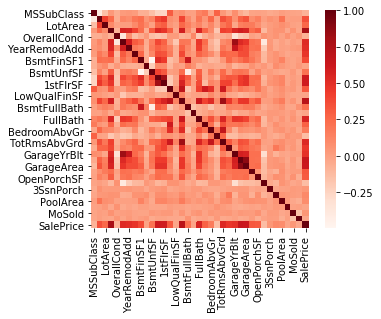

In [11]:
correlation = data.corr()
fig = plt.subplots()
sns.heatmap(correlation,vmax=1,square=True,cmap='Reds')
# A tak się korelujo

In [14]:
data.describe(include = 'all')

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
count,1460.000000,1460,1201.000000,1460.000000,1460,91,1460,1460,1460,1460,...,1460.000000,7,281,54,1460.000000,1460.000000,1460.000000,1460,1460,1460.000000
unique,NaN,5,NaN,NaN,2,2,4,4,2,5,...,NaN,3,4,4,NaN,NaN,NaN,9,6,NaN
top,NaN,RL,NaN,NaN,Pave,Grvl,Reg,Lvl,AllPub,Inside,...,NaN,Gd,MnPrv,Shed,NaN,NaN,NaN,WD,Normal,NaN
freq,NaN,1151,NaN,NaN,1454,50,925,1311,1459,1052,...,NaN,3,157,49,NaN,NaN,NaN,1267,1198,NaN
mean,56.897260,NaN,70.049958,10516.828082,NaN,NaN,NaN,NaN,NaN,NaN,...,2.758904,NaN,NaN,NaN,43.489041,6.321918,2007.815753,NaN,NaN,180921.195890
std,42.300571,NaN,24.284752,9981.264932,NaN,NaN,NaN,NaN,NaN,NaN,...,40.177307,NaN,NaN,NaN,496.123024,2.703626,1.328095,NaN,NaN,79442.502883
min,20.000000,NaN,21.000000,1300.000000,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,NaN,NaN,NaN,0.000000,1.000000,2006.000000,NaN,NaN,34900.000000
25%,20.000000,NaN,59.000000,7553.500000,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,NaN,NaN,NaN,0.000000,5.000000,2007.000000,NaN,NaN,129975.000000
50%,50.000000,NaN,69.000000,9478.500000,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,NaN,NaN,NaN,0.000000,6.000000,2008.000000,NaN,NaN,163000.000000
75%,70.000000,NaN,80.000000,11601.500000,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,NaN,NaN,NaN,0.000000,8.000000,2009.000000,NaN,NaN,214000.000000


In [22]:
#wybieram sobie takie dane do dalszej analizy
df = data[['LotArea', 'YearBuilt', 'GarageArea', 'SalePrice']]
df.describe()

,LotArea,YearBuilt,GarageArea,SalePrice
count,1460.000000,1460.000000,1460.000000,1460.000000
mean,10516.828082,1971.267808,472.980137,180921.195890
std,9981.264932,30.202904,213.804841,79442.502883
min,1300.000000,1872.000000,0.000000,34900.000000
25%,7553.500000,1954.000000,334.500000,129975.000000
50%,9478.500000,1973.000000,480.000000,163000.000000
75%,11601.500000,2000.000000,576.000000,214000.000000
max,215245.000000,2010.000000,1418.000000,755000.000000


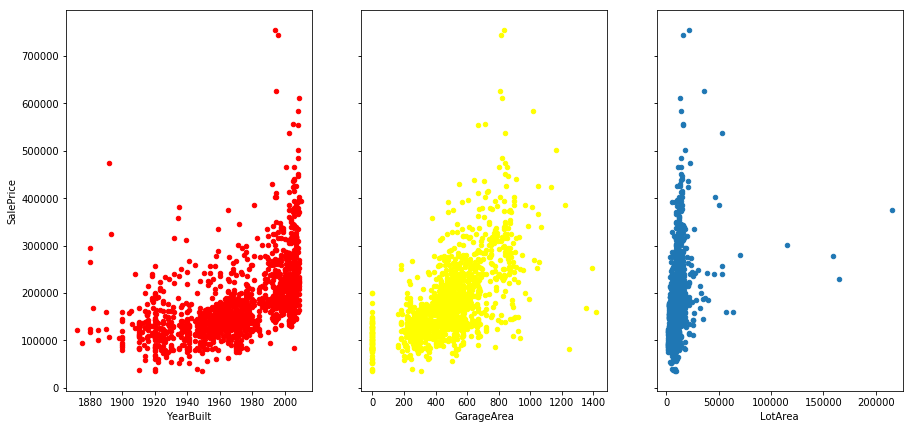

In [28]:
fig, axs = plt.subplots(1, 3, sharey = True)
# wykresy
df.plot(kind = 'scatter', x = 'YearBuilt', y = 'SalePrice', ax = axs[0], figsize=(15, 7), color='red')
df.plot(kind = 'scatter', x = 'GarageArea', y = 'SalePrice', ax = axs[1], color='yellow')
df.plot(kind = 'scatter', x = 'LotArea', y = 'SalePrice', ax = axs[2])

In [43]:
df = df[(df.LotArea < 50000) & (df.YearBuilt > 1920) & (df.GarageArea < 1000)]

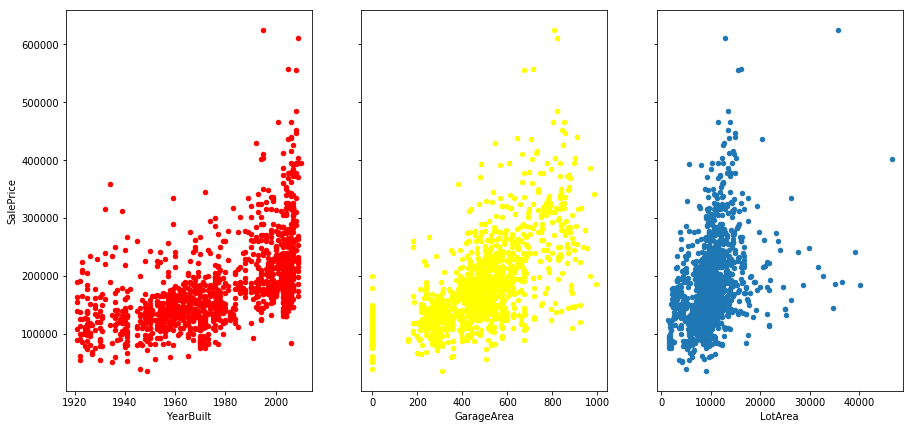

In [44]:
fig, axs = plt.subplots(1, 3, sharey = True)
# wykresy
df.plot(kind = 'scatter', x = 'YearBuilt', y = 'SalePrice', ax = axs[0], figsize=(15, 7), color='red')
df.plot(kind = 'scatter', x = 'GarageArea', y = 'SalePrice', ax = axs[1], color='yellow')
df.plot(kind = 'scatter', x = 'LotArea', y = 'SalePrice', ax = axs[2])

In [70]:
df.describe(include = 'all')

,LotArea,YearBuilt,GarageArea,SalePrice
count,1315.000000,1315.000000,1315.000000,1315.000000
mean,9810.013688,1976.451711,474.981749,181808.135361
std,4454.799436,24.975234,194.894132,73399.511771
min,1300.000000,1921.000000,0.000000,35311.000000
25%,7549.000000,1958.000000,351.000000,133000.000000
50%,9473.000000,1976.000000,480.000000,166000.000000
75%,11519.000000,2002.000000,576.000000,214950.000000
max,46589.000000,2010.000000,995.000000,625000.000000


In [89]:
params = ['LotArea', 'GarageArea', 'YearBuilt']
price = ['SalePrice']

# train
X  = df[params][:-100]
Y  = df[price][:-100]

# test
Xt = df[params][:100]
Yt = df[price][:100]

In [90]:
# lasso 
lasso = linear_model.Lasso(alpha = 1)
lasso.fit(X, Y)

P = lasso.predict(Xt)

print(lasso.coef_)
print(metrics.mean_squared_error(Yt, P))

[    4.11044972   137.41394539  1112.6167665 ]
1715334211.75


In [84]:
# reg lin zwykla
lin = linear_model.LinearRegression()
lin.fit(X, Y)

P = lin.predict(Xt)

print( lin.coef_)
print(metrics.mean_squared_error(Yt, P)) # hm

[[    4.11045086   137.41381357  1112.6189406 ]]
1715334351.73


In [92]:
ridge = linear_model.Ridge(alpha = 1)
ridge.fit(X, Y)

P = ridge.predict(Xt)

print( ridge.coef_)
print(metrics.mean_squared_error(Yt, P))

[[    4.11044949   137.41396725  1112.61681237]]
1715334223.05


In [95]:
# jeszcz emoze elastic
enet = linear_model.ElasticNet(alpha = 1, l1_ratio = 0.5)
enet.fit(X, Y)

P = enet.predict(Xt)

print(enet.coef_)
print(metrics.mean_squared_error(Yt, P))

[    4.1096194    137.50712254  1111.32647686]
1715256936.65


In [ ]:
# elastic zdaje się być najlpeszy, ale no takie średnie te wyniki chyba